# MT Competition



## Libraries

In [2]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

import os
import json
import csv
import gc
from time import strptime, localtime, strftime
from tqdm import tqdm
import logging
from datetime import datetime

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer

### Setting configs

In [3]:
MAX_LENGTH = 20

EMBEDDING_DIM = 256
ENCODER_HIDDEN_SIZE = 512
DECODER_HIDDEN_SIZE = 512

ENCODER_NUM_LAYERS = 2
DECODER_NUM_LAYERS = 2

MAX_VOCAB = 30_000

TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pd.set_option('mode.chained_assignment',None)
os.environ['PYTORCH_NO_CUDA_MEMORY_CACHING'] = "0"
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = "max_split_size_mb:100"

logging.basicConfig(filename='taurus.log', filemode='w+')

## Data loading

In [4]:
# Convert json data files to DataFrames

def convert_json_to_df(filepath) -> DataFrame:
    with open(filepath, 'r', encoding='utf-8') as f:
        data = pd.read_json(f)

    languages = data.columns

    all_data = []
    for lang in tqdm(languages, ncols=100, desc="Loading data"):
        new_frame = DataFrame(data.iloc[0][lang]).T
        new_frame['language'] = lang
        all_data.append(new_frame)
    
    all_data = pd.concat(all_data)
    return all_data


In [5]:
languages = {
    'English-Hindi': TRAIN_BATCH_SIZE, 
    'English-Bengali': TRAIN_BATCH_SIZE,
    'English-Gujarati': TRAIN_BATCH_SIZE,
    'English-Malayalam': TRAIN_BATCH_SIZE,
    'English-Telgu': TRAIN_BATCH_SIZE, 
    'English-Kannada': TRAIN_BATCH_SIZE,
    'English-Tamil': 32
}

time_val = strptime("28-09-23 10_20", "%d-%m-%y %H_%M")
print('Localtime:', strftime("%d-%m-%y %H_%M", time_val))
import os
dir_path = os.path.join('answers', strftime("%d-%m-%y %H_%M", time_val))
if not(os.path.exists(dir_path)):
    os.makedirs(dir_path)

data = convert_json_to_df('../train_data1.json').dropna().reset_index(names=['id'])
data['source_len'] = data['source'].apply(lambda x: len(x))
data['target_len'] = data['target'].apply(lambda x: len(x))


val_data = convert_json_to_df('../val_data1.json').fillna('').reset_index(names=['id'])
val_data['source_len'] = val_data['source'].apply(lambda x: len(x))

test_data = convert_json_to_df('../test_data1_final.json').fillna('').reset_index(names=['id'])
test_data['source_len'] = test_data['source'].apply(lambda x: len(x))

timing_data = DataFrame(data=None, columns=['start_time', 'end_time', 'turnaround_time'], index=languages)
if os.path.exists(os.path.join('answers',strftime("%d-%m-%y %H_%M", time_val),f'timings.csv')):
    td = pd.read_csv(os.path.join('answers',strftime("%d-%m-%y %H_%M", time_val),f'timings.csv'))
    timing_data = td

Localtime: 28-09-23 10_20


Loading data: 100%|███████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.40it/s]


### Data Analysis

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme('notebook')

In [7]:
lang_stats = pd.DataFrame(columns=['English', 'Hindi', 'Gujarati', 'Bengali', 'Tamil', 'Telgu', 'Malayalam', 'Kannada', 'id'])

lang_stats['English'] = data['source'].apply(lambda x: len(x))
lang_stats['Hindi'] = data.loc[data['language'] == 'English-Hindi', 'target'].apply(lambda x: len(x))
lang_stats['Gujarati'] = data.loc[data['language'] == 'English-Gujarati', 'target'].apply(lambda x: len(x))
lang_stats['Bengali'] = data.loc[data['language'] == 'English-Bengali', 'target'].apply(lambda x: len(x))
lang_stats['Tamil'] = data.loc[data['language'] == 'English-Tamil', 'target'].apply(lambda x: len(x))
lang_stats['Telgu'] = data.loc[data['language'] == 'English-Telgu', 'target'].apply(lambda x: len(x))
lang_stats['Kannada'] = data.loc[data['language'] == 'English-Kannada', 'target'].apply(lambda x: len(x))
lang_stats['Malayalam'] = data.loc[data['language'] == 'English-Malayalam', 'target'].apply(lambda x: len(x))
lang_stats['id'] = data['id']

color_pallete = {}
pal = sns.color_palette('muted').as_hex()
for column, color in zip(['English', 'Hindi', 'Gujarati', 'Bengali', 'Tamil', 'Telgu', 'Malayalam', 'Kannada'], pal):
    color_pallete[column] = color

# print(lang_stats.describe().astype(int).to_latex())
lang_stats.describe().astype(int)

,English,Hindi,Gujarati,Bengali,Tamil,Telgu,Malayalam,Kannada
count,401246,80797,47482,68849,58361,44905,54057,46795
mean,92,94,90,86,107,84,96,86
std,53,55,43,46,58,45,52,46
min,0,1,0,2,3,0,2,0
25%,56,54,59,53,64,51,58,52
50%,85,85,83,80,97,77,89,79
75%,120,123,115,113,140,110,126,113
max,12732,1203,519,628,662,524,1133,662


Outlier sentence with length greater than 12,000

In [8]:
print(data.loc[data['source_len'] >= 12000, 'source'].values)

['The capital of Aceh is Banda Aceh. The Special Province of Aceh with its area of 57, 365.57 square kilometers covering 1.17 per cent of Indonesia is situated at the northern tip of Sumatra Island, between latitudes 2°N and longitudes 95°E-98°E. In the central part of this province runs Bukit Barisan Mountain ranges with Tangse, Gayo, and Alas uplands.Also, there are several mountains found in the region such as Pasee Mountain with its peak, Geureudong" (2,595 m), and Peut Sagoe (2,708 m), Gayo Mountain range with its peak Burni Telong (2,566 m), and Ucap Malu Mountain range (3,187 m)Other mountains include: Alas mountain with its peak Abong-abong (3,015 m) Leuser (3,466 m), Aceh" Raya Mountain range with its peak Seulawah Agam, (1,762 m) and Seulawah Inong Mountain (868 m).The area also has several lakes such as Laut Tawar Lake in Central Aceh with an area of 60 square kilometers and a height of 1,225 meters above sea level, and also lake Aneuk Laot in Sabang (Weh Island).Besides the

Number of sentences in each language

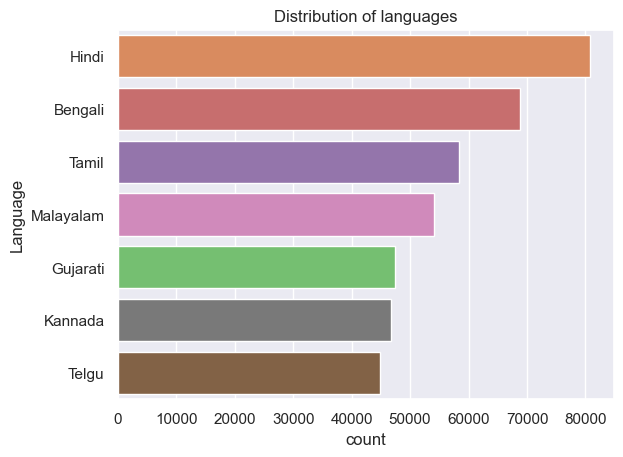

In [9]:
plot_data = lang_stats.describe().loc['count'].to_frame().reset_index(names=['Language'])
plot_data = plot_data[plot_data['Language'] != 'English']
sns.barplot(data = plot_data.sort_values(by='count', ascending=False), y='Language', x='count', palette=color_pallete)
plt.title('Distribution of languages')

plt.savefig('images/lang-distribution.pdf', bbox_inches="tight")
plt.savefig('images/lang-distribution.svg', bbox_inches="tight")

Let's look at how the lengths of sentences are in each language compared the each other. All the distributions seem to be right-skewed

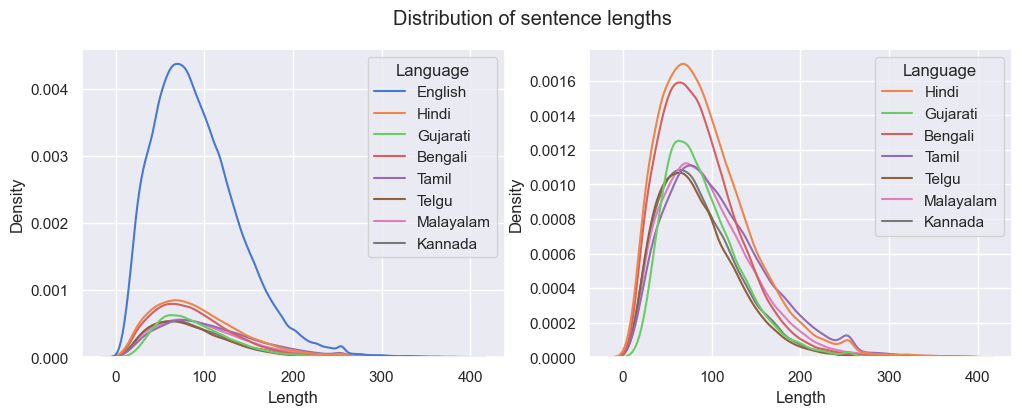

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_data = lang_stats[['English', 'Hindi', 'Gujarati', 'Bengali', 'Tamil', 'Telgu', 'Malayalam', 'Kannada']].melt().rename(columns={'variable': 'Language', 'value': 'Length'})
sns.kdeplot(plot_data[plot_data['Length'] < 400], x='Length', hue='Language', palette = color_pallete, ax = ax[0])

plot_data = lang_stats[['Hindi', 'Gujarati', 'Bengali', 'Tamil', 'Telgu', 'Malayalam', 'Kannada']].melt().rename(columns={'variable': 'Language', 'value': 'Length'})
sns.kdeplot(plot_data[plot_data['Length'] < 400], x='Length', hue='Language', palette = color_pallete, ax = ax[1])


fig.suptitle('Distribution of sentence lengths')

plt.savefig('images/length-distribution.pdf', bbox_inches="tight")
plt.savefig('images/length-distribution.svg', bbox_inches="tight")

Let's look at the CDF to find an optimal point to clip sentences for training

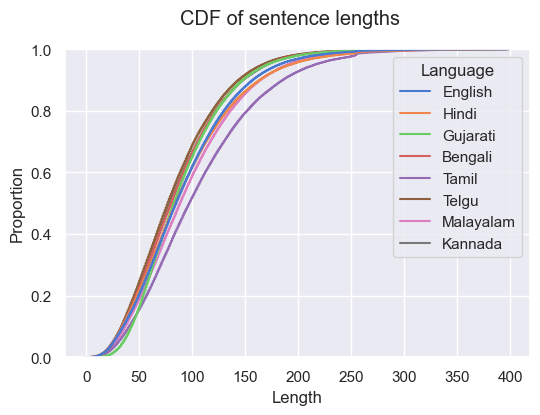

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plot_data = lang_stats[['English', 'Hindi', 'Gujarati', 'Bengali', 'Tamil', 'Telgu', 'Malayalam', 'Kannada']].melt().rename(columns={'variable': 'Language', 'value': 'Length'})
sns.ecdfplot(plot_data[plot_data['Length'] < 400], x='Length', hue='Language', palette = color_pallete)

fig.suptitle('CDF of sentence lengths')

plt.savefig('images/length-cdf.pdf', bbox_inches="tight")
plt.savefig('images/length-cdf.svg', bbox_inches="tight")

Let's look at the distribution of unique words in each language to make estimates about the vocab size

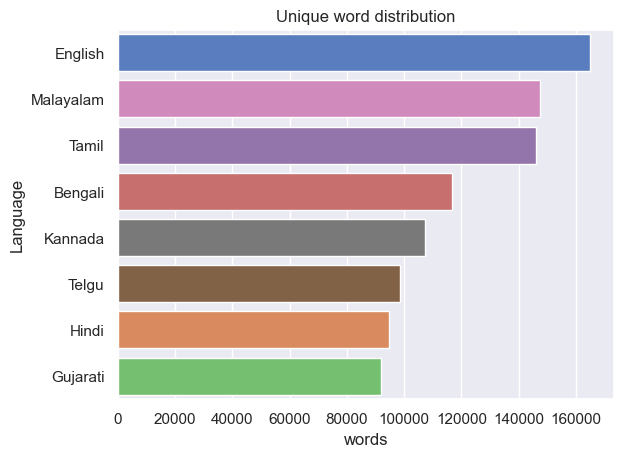

In [12]:
lang_sentences = pd.DataFrame(columns=['English', 'Hindi', 'Gujarati', 'Bengali', 'Tamil', 'Telgu', 'Malayalam', 'Kannada', 'id'])

lang_sentences['English'] = data['source'].apply(lambda x: x.split())
lang_sentences['Hindi'] = data.loc[data['language'] == 'English-Hindi', 'target'].apply(lambda x: x.split())
lang_sentences['Gujarati'] = data.loc[data['language'] == 'English-Gujarati', 'target'].apply(lambda x: x.split())
lang_sentences['Bengali'] = data.loc[data['language'] == 'English-Bengali', 'target'].apply(lambda x: x.split())
lang_sentences['Tamil'] = data.loc[data['language'] == 'English-Tamil', 'target'].apply(lambda x: x.split())
lang_sentences['Telgu'] = data.loc[data['language'] == 'English-Telgu', 'target'].apply(lambda x: x.split())
lang_sentences['Kannada'] = data.loc[data['language'] == 'English-Kannada', 'target'].apply(lambda x: x.split())
lang_sentences['Malayalam'] = data.loc[data['language'] == 'English-Malayalam', 'target'].apply(lambda x: x.split())
lang_sentences['id'] = data['id']

color_pallete = {}
pal = sns.color_palette('muted').as_hex()
for column, color in zip(['English', 'Hindi', 'Gujarati', 'Bengali', 'Tamil', 'Telgu', 'Malayalam', 'Kannada'], pal):
    color_pallete[column] = color

lang_sentences
# print(lang_stats.describe().astype(int).to_latex())
# lang_sentences.describe().astype(int)

def get_unique_words(lang):
    words = []
    for sentence in lang_sentences[lang].values:
        if type(sentence) is list:
            words.extend(list(sentence))
    return len(set(words))

lang_words = pd.DataFrame(index=['English', 'Hindi', 'Gujarati', 'Bengali', 'Tamil', 'Telgu', 'Malayalam', 'Kannada'], columns=['words'])
lang_words.loc['English', 'words'] = get_unique_words('English')
lang_words.loc['Hindi', 'words'] = get_unique_words('Hindi')
lang_words.loc['Gujarati', 'words'] = get_unique_words('Gujarati')
lang_words.loc['Bengali', 'words'] = get_unique_words('Bengali')
lang_words.loc['Tamil', 'words'] = get_unique_words('Tamil')
lang_words.loc['Telgu', 'words'] = get_unique_words('Telgu')
lang_words.loc['Malayalam', 'words'] = get_unique_words('Malayalam')
lang_words.loc['Kannada', 'words'] = get_unique_words('Kannada')

lang_words = lang_words.reset_index(names=['Language'])

sns.barplot(data = lang_words.sort_values(by='words', ascending=False), y='Language', x='words', palette=color_pallete)
plt.title('Unique word distribution')

plt.savefig('images/word-distribution.pdf', bbox_inches="tight")
plt.savefig('images/word-distribution.svg', bbox_inches="tight")


Comparing the lengths of the source and target sentences in all the languages we see a linear trend between the number of words between 20 words and 150 words. This also helps in finding possible outliers at length 0 in all the languages. We also observe that we loose the linear relationship between sentences when the sources are beyond 200 words.

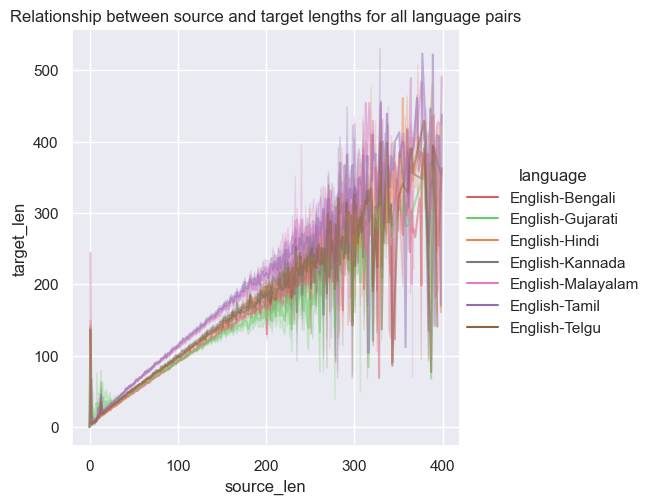

In [13]:
plot_data = data[['source_len', 'target_len', 'language']]

color_pallete = {}
pal = sns.color_palette('muted').as_hex()
for column, color in zip(['[]', 'English-Hindi', 'English-Gujarati', 'English-Bengali', 'English-Tamil', 'English-Telgu', 'English-Malayalam', 'English-Kannada'], pal):
    color_pallete[column] = color

sns.relplot(data=plot_data[plot_data['source_len'] < 400], x='source_len', y='target_len', hue='language', palette=color_pallete, kind='line', alpha=0.5)
plt.title('Relationship between source and target lengths for all language pairs')

plt.savefig('images/len-comparision.pdf', bbox_inches="tight")
plt.savefig('images/len-comparision.svg', bbox_inches="tight")


### Tokenization

In [14]:
class MTAllTokenizerBPE:
    def __init__(self, languages: list=[]) -> None:
        lang_tokenizer = Tokenizer(BPE(unk_token = "[UNK]"))
        lang_tokenizer.pre_tokenizer = Whitespace()
        self.trainer = BpeTrainer(special_tokens=["[PAD]", "[UNK]", "[SOS]", "[EOS]", "[MASK]"])

        self.tokenizer = {
            'English': lang_tokenizer
        }


    def __call__(self, data: DataFrame, **kwargs) -> DataFrame:
        # data = pd.read_csv(filepath, encoding='utf-8').dropna()
        is_val = True if data.iloc[0].shape[0] == 2 else False
        if (not(is_val)):
            self.__train_tokenizer(data, kwargs=kwargs)
        return self.tokenizer

    
    def __train_tokenizer(self, data, **kwargs):
        max_vocab = kwargs['max_vocab'] if 'max_vocab' in kwargs else 30_000
        save_filedir = kwargs['save_filedir'] if 'save_filedir' in kwargs else './tokenizers'
        languages = list(set(data['language']))

        if len(os.listdir(save_filedir)) >= 8:
            self.get_tokenizers(languages, save_filedir)
        
        else:
            self.tokenizer['English'].train_from_iterator(
                list(data['source']), self.trainer)
            for lang in tqdm(languages, ncols=100, desc="Training tokenizer"):
                self.tokenizer[lang] = Tokenizer(BPE(unk_token = "[UNK]"))
                self.tokenizer[lang].pre_tokenizer = Whitespace()
                lang_data = data[data['language'] == lang]
                self.tokenizer[lang].train_from_iterator(
                    list(lang_data['target']), self.trainer)
            
            for lang, tokenizer in self.tokenizer.items():
                if not(os.path.exists(save_filedir)):
                    os.makedirs(save_filedir)
                self.tokenizer[lang].save(os.path.join(save_filedir, f'{lang}_tokenizer.json'))

    
    def get_tokenizers(self, languages: list, save_filedir: str):
        save_file = os.path.join(save_filedir, f'English_tokenizer.json')
        self.tokenizer['English'] = Tokenizer.from_file(save_file)
        for lang in tqdm(languages, ncols=100, desc="Getting tokenizer"):
            save_file = os.path.join(save_filedir, f'{lang}_tokenizer.json')
            self.tokenizer[lang] = Tokenizer.from_file(save_file)
    
    
    def tokenize_pairs(self, source, target = None, language = None):
        source_tokens = self.tokenizer['English'].encode(source).ids
        if target == None or language == None:
            return source_tokens, []
        target_tokens = self.tokenizer[language].encode(target).ids
        return source_tokens, target_tokens
    

alltokenizer = MTAllTokenizerBPE(languages)
tokenizer = alltokenizer(data, save_filedir='tokenizers')

Getting tokenizer: 100%|██████████████████████████████████████████████| 7/7 [00:00<00:00, 35.03it/s]


### Dataset

In [15]:
class MTLanguageData:
    def __init__(self, language, tokenizer) -> None:
        self.language = language
        self.tokenizer = tokenizer
    
    
    def __call__(self, data: DataFrame, *args, **kwargs):
        lang_data = data[data['language'] == self.language]
        lang_data['source_tokens'] = lang_data.loc[:,'source'].apply(
            lambda x: self.__get_tokens__(x, self.tokenizer['English'])).values
        if 'target' in lang_data.columns:
            lang_data['target_tokens'] = lang_data.loc[:,'target'].apply(
                lambda x: self.__get_tokens__(x, self.tokenizer[self.language])).values
        return lang_data

    @staticmethod
    def __get_tokens__(line, tokenizer):
        return tokenizer.encode(line).ids + [3]
    
class MTDataset(Dataset):
    def __init__(self, sources, targets, ids):
        super().__init__()
        self.sources = sources
        self.targets = targets
        self.ids = ids
    def __getitem__(self, index):
        if len(self.targets) > 0:
            return (self.sources[index], self.targets[index], self.ids[index])
        return (self.sources[index], [], self.ids[index])
    
    def __len__(self):
        return len(self.sources)

def pad_source_targets(batch, max_len = 120):
    sources = pad_sequence([torch.tensor(s) for s, _, _ in batch], batch_first=True)[:, :max_len]
    targets = pad_sequence([torch.tensor(t) for _, t, _ in batch], batch_first=True)[:, :max_len]
    ids = torch.tensor([torch.tensor(idx) for _, _, idx in batch])
    return sources, targets, ids

## Model and Training

### Seq2Seq Model

In [16]:
class EncoderGRU(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, num_layers, dropout_p=0.1, batch_first = False, bidirectional=True) -> None:
        super(EncoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_dim = embedding_dim

        self.embedding = nn.Embedding(input_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers=num_layers, batch_first=batch_first, bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input_val):
        return self.gru(self.dropout(self.embedding(input_val)))
    

class DecoderGRU(nn.Module):
    def __init__(self, hidden_size, embedding_size, num_layers, encoder_num_layers, output_size, dropout_p=0.1, batch_first = False, bidirectional = True, encoder_birectional = True, device = 'cpu') -> None:
        super(DecoderGRU, self).__init__()
        self.embedding = nn.Embedding(output_size, embedding_size, padding_idx=0)
        D = 2 if encoder_birectional == True else 1
        self.gru = nn.GRU(embedding_size + D*ENCODER_HIDDEN_SIZE, hidden_size, num_layers=num_layers, batch_first=batch_first, dropout=dropout_p, bidirectional=bidirectional)
        D = 2 if bidirectional == True else 1
        self.out = nn.Linear(D*hidden_size, output_size)
        self.device = device
        self.hidden_size = hidden_size

    def forward(self, encoder_outputs, encoder_hidden, source_len, target_tensor = None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.int, device=self.device).fill_(2)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        source_len = min(source_len, target_tensor.size(1)) if target_tensor is not None else source_len

        # We have only a single context vector. Taking the last output of
        # the encoder output as the `context_vector`
        context_vector = encoder_outputs[:,-1,:].unsqueeze(1)

        # try:
        for i in range(source_len):
            decoder_output, decoder_hidden = self.forward_step(decoder_input, context_vector, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None: # Teacher Forcing
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else: # No Teacher Forcing
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs = F.log_softmax(torch.cat(decoder_outputs, dim=1), dim=1)
        return decoder_outputs, decoder_hidden, None

    def forward_step(self, input_val, context_vector, hidden):
        embedded = F.relu(self.embedding(input_val))
        # Concatenating context vector with target embeddings
        gru_input = torch.cat((embedded, context_vector), dim=2)
        output, hidden = self.gru(gru_input, hidden)
        output = self.out(output)
        return output, hidden

def create_encoder():
    return EncoderGRU(MAX_VOCAB, EMBEDDING_DIM, ENCODER_HIDDEN_SIZE, ENCODER_NUM_LAYERS, batch_first=True, bidirectional=True).to(device)

def create_decoder():
    return DecoderGRU(DECODER_HIDDEN_SIZE, EMBEDDING_DIM, DECODER_NUM_LAYERS, ENCODER_NUM_LAYERS, MAX_VOCAB, device=device, batch_first=True, bidirectional=True).to(device)

def load_weights_if_exists(encoder, decoder, encoder_filepath, decoder_filepath):
    if os.path.exists(encoder_filepath) and os.path.exists(decoder_filepath):
        print('Loading stored weights')
        encoder.load_state_dict(torch.load(encoder_filepath))
        decoder.load_state_dict(torch.load(decoder_filepath))
        encoder = encoder.to(device)
        decoder = decoder.to(device)
    return encoder, decoder

encoder = create_encoder()

### Training loop

In [17]:

def train_epoch(dataloader, encoder, decoder, encoder_optim, decoder_optim, loss_fn, encoder_eval = False):
    total_loss = 0
    batch_losses = []
    if encoder_eval:
        encoder.eval()
    else:
        encoder.train()
    decoder.train()
    for batch in tqdm(dataloader, ncols=100, desc="Training"):
        source = batch[0].to(device)
        target = batch[1][:, :source.size(1)].to(device)
        # source = torch.stack([s for s, _, _ in batch]).to(device)
        # target = torch.stack([t[1:source.size(1)] for _, t, _ in batch]).to(device)
        # target_ohe = F.one_hot(target, num_classes=len(target_vocab[0]))
        encoder_optim.zero_grad()
        decoder_optim.zero_grad()
        if encoder_eval:
            with torch.no_grad():
                encoder_outputs, encoder_hidden = encoder(source)
        else:
            encoder_outputs, encoder_hidden = encoder(source)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, source.size(1), target)

        loss = loss_fn(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target.type(torch.long).view(-1))

        loss.backward()

        encoder_optim.step()
        decoder_optim.step()

        total_loss += loss.item()
        batch_losses.append(loss.item())

    del source
    del target
    torch.cuda.empty_cache()
    gc.collect()
    return total_loss/len(dataloader), batch_losses

def train(dataloader, encoder, decoder, n_epochs, encoder_eval = False, lr=1e-3):
    plot_losses = []
    plot_batch_losses = []
    encoder_optim = optim.Adam(encoder.parameters(), lr = lr)
    decoder_optim = optim.Adam(decoder.parameters(), lr = lr)
    loss_fn = nn.NLLLoss(ignore_index=0)
    # loss_fn = nn.CrossEntropyLoss(ignore_index=0)

    for epoch in range(1, n_epochs+1):
        loss, batch_loss = train_epoch(dataloader, encoder, decoder, encoder_optim, decoder_optim, loss_fn, encoder_eval=encoder_eval)
        plot_losses.append(loss)
        plot_batch_losses.extend(batch_loss)
    return plot_losses, plot_batch_losses

def train_and_save_language(language, tokenizer: MTAllTokenizerBPE, data, encoder, decoder, batch_size, epochs, encoder_filepath, decoder_filepath, encoder_eval = False):
    eh = MTLanguageData(language, tokenizer)
    train_data = eh(data)

    train_data = train_data.sort_values(by=['source_len'])
    train_data[train_data['source_len'] <= 35]

    dataset = MTDataset(
        train_data['source_tokens'].values, 
        train_data['target_tokens'].values, 
        train_data['id'].values.astype('int'))
    dataloader = DataLoader(dataset, batch_size = batch_size, collate_fn=pad_source_targets)
    try:
        _, _ = train(dataloader, encoder, decoder, epochs, encoder_eval=encoder_eval)
    except Exception as e:
        logging.error('Error in train', e)
    finally:
        torch.save(encoder.state_dict(), encoder_filepath)
        torch.save(decoder.state_dict(), decoder_filepath)

### Evaluating on validation and test data

In [18]:
def evaluate(dataloader, encoder, decoder):    
    translated_output = []
    encoder.eval()
    decoder.eval()
    val_ids = []
    with torch.no_grad():
        with torch.inference_mode():
            for batch in tqdm(dataloader, ncols=100, desc="Evaluating"):
                try:
                    source = batch[0].to(device)
                    encoder_outputs, encoder_hidden = encoder(source)
                    decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, 30)
                    yield batch[2], decoder_outputs.detach().cpu()
                except Exception as e:
                    print(batch[2])
                    print(e.with_traceback())

def translate_sentences(translated_gen, tokenizer: MTAllTokenizerBPE, language):
    translated_sentences = []
    target_vocab = tokenizer[language]
    for id_vals, translated in tqdm(translated_gen, ncols=100, desc="Translating"):
        for id, sentence in zip(id_vals, translated):
            # print(batch.shape)
            words = sentence.argmax(dim=1).detach().cpu().numpy()
            # print(sentences.shape)
            sent = target_vocab.decode(words)
            sent = f'{id}\t"{sent}"\n'
            translated_sentences.append(sent)
    return translated_sentences

def load_and_predict_language(language, tokenizer: MTAllTokenizerBPE, data, encoder, decoder, batch_size, encoder_filepath, decoder_filepath, answer_filepath):
    encoder.load_state_dict(torch.load(encoder_filepath))
    decoder.load_state_dict(torch.load(decoder_filepath))
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    eh = MTLanguageData(language, tokenizer)
    val_data = eh(data)
    
    dataset = MTDataset(val_data['source_tokens'].values, [], val_data['id'].values.astype(int))
    dataloader = DataLoader(dataset, batch_size = batch_size, collate_fn=pad_source_targets)

    translated_gen = evaluate(dataloader, encoder, decoder)

    translated_sentences = translate_sentences(translated_gen, tokenizer, language)

    with open(answer_filepath, 'w', encoding='utf-8') as f:
        # f.write('"ID"\t"Translation"\n')
        f.writelines(translated_sentences)

In [95]:
for lang, batch_size in languages.items():
    # Different decoder for each language
    decoder = create_decoder()
    
    encoder_filepath = os.path.join('answers',strftime("%d-%m-%y %H_%M", time_val),f'encoderBiGRU_{lang}.pkl')
    decoder_filepath = os.path.join('answers',strftime("%d-%m-%y %H_%M", time_val),f'decoderBiGRU_{lang}.pkl')
    answer_filepath = os.path.join('answers',strftime("%d-%m-%y %H_%M", time_val),f'answer_{lang}.csv')
    
    encoder, decoder = load_weights_if_exists(encoder, decoder, encoder_filepath, decoder_filepath)
    # lang = 'English-'+lang
    start_time = datetime.now()

    train_and_save_language(
        lang, tokenizer, data, encoder, decoder, batch_size, 10,
        encoder_filepath, decoder_filepath, encoder_eval=True)
    
    # target_vocab = get_target_vocab(lang, '../train_data1.json')
    load_and_predict_language(
        lang, tokenizer, val_data, encoder, decoder, VAL_BATCH_SIZE, 
        encoder_filepath, decoder_filepath, answer_filepath)
    
    end_time = datetime.now()
    tt = end_time - start_time
    timing_data.loc[lang, 'start_time'] = start_time.strftime('%d/%m/%Y %H:%M:%S')
    timing_data.loc[lang, 'end_time'] = end_time.strftime('%d/%m/%Y %H:%M:%S')
    timing_data.loc[lang, 'turnaround_time'] = f'{tt.seconds//3600}:{tt.seconds//60}:{tt.seconds%60}'

timing_data.to_csv(
    os.path.join('answers',strftime("%d-%m-%y %H_%M", time_val),f'timings.csv'),
)


Loading stored weights


Training:  59%|█████████████████████████████▊                     | 370/632 [08:17<05:52,  1.35s/it]


KeyboardInterrupt: 

In [42]:
# Translating a sentence
def evaluate_and_translate(sentence, language, tokenizer, encoder, decoder, encoder_filepath, decoder_filepath):
    assert language in encoder_filepath
    assert language in decoder_filepath
    encoder.load_state_dict(torch.load(encoder_filepath))
    decoder.load_state_dict(torch.load(decoder_filepath))
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    encoder.eval()
    decoder.eval()
    sent = None

    sentence = tokenizer['English'].encode(sentence).ids + [3]
    source_len = len(sentence)
    with torch.inference_mode():
        with torch.no_grad():
            source = torch.tensor(sentence).unsqueeze(0).to(device)
            encoder_output, encoder_hidden = encoder(source)
            decoder_outputs, _, _ = decoder(encoder_output, encoder_hidden, source_len)
            words = decoder_outputs.argmax(dim=2).detach().cpu().numpy().reshape(-1)
            # print(words)
            # return
            sent = tokenizer[f'English-{language}'].decode(words)
    
    return sent
    

In [49]:
encoder = create_encoder()
decoder = create_decoder()
language = 'Hindi'
lang = 'English-{}'.format(language)
encoder_filepath = os.path.join('answers',strftime("%d-%m-%y %H_%M", time_val),f'encoderBiGRU_{lang}.pkl')
decoder_filepath = os.path.join('answers',strftime("%d-%m-%y %H_%M", time_val),f'decoderBiGRU_{lang}.pkl')

translated_sent = evaluate_and_translate(
    'This is the end',
    language,
    tokenizer,
    encoder,
    decoder,
    encoder_filepath,
    decoder_filepath
)

translated_sent

'alexa विंग \u200c यह घोषणा'

In [54]:
pd.read_csv(os.path.join(dir_path, 'timings.csv'), encoding='utf-8')

,language,start_time,end_time,turnaround_time
0,English-Hindi,28/09/2023 10:24:30,28/09/2023 10:34:27,0:9:57
1,English-Bengali,28/09/2023 10:34:27,28/09/2023 10:42:43,0:8:15
2,English-Gujarati,28/09/2023 10:42:43,28/09/2023 10:48:36,0:5:52
3,English-Malayalam,28/09/2023 10:48:37,28/09/2023 10:55:08,0:6:31
4,English-Telgu,28/09/2023 10:55:08,28/09/2023 11:00:22,0:5:14
5,English-Kannada,28/09/2023 11:00:22,28/09/2023 11:05:53,0:5:30
6,English-Tamil,28/09/2023 11:05:53,28/09/2023 11:25:23,0:19:30
